In [1]:
import os
import pandas as pd
import upsetplot
from functools import reduce
from itertools import combinations

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [8]:
groups = ["british", "lifestyle"]

gene_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/combo_genes.list",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/lifestyle/combo_genes.list",
    ]

go_enrich_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/GO_Biological_Process_2023_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/lifestyle/GO_Biological_Process_2023_enrich.csv",
]

kegg_enrich_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/KEGG_2021_Human_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/lifestyle/KEGG_2021_Human_enrich.csv",
]

In [9]:
def read_genes(gene_file):
    with open(gene_file, "r") as f:
        genes = set([g.strip() for g in f.readlines()])
    return genes

def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(group_sets, groups):
    # get the set of items for each group
    item_dict = {g: s for g,s in zip(groups, group_sets)}
    item_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_items = list(combinations(groups, i))
        for items in all_items:
            # get counts of elements that are unique to the group
            include_items = items
            exclude_items = tuple(g for g in groups if g not in include_items)
            include_sets = [item_dict[c] for c in include_items]
            exclude_sets = [item_dict[c] for c in exclude_items]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_items, exclude_items)] = unique_intersects
            for c in include_items:
                item_boolean_dict[c].append(True)
            for c in exclude_items:
                item_boolean_dict[c].append(False)
    item_boolean_dict["counts"] = counts
    df = pd.DataFrame(item_boolean_dict)
    return df.set_index(groups), unique_intersect_sets

# Genes

In [10]:
group_genes = list(map(read_genes, gene_files))

In [11]:
gene_upset_df, gene_unique_intersects = get_upset_df(group_genes, groups)

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


(0.0, 1.0, 0.0, 1.0)

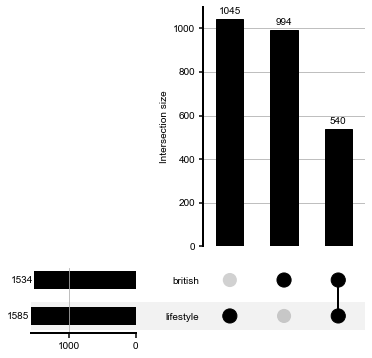

In [12]:
parsed_gene_upset_df = gene_upset_df.loc[gene_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(6, 6))
upsetplot.plot(parsed_gene_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

# GO terms

In [13]:
def read_enrich_files(filename):
    df = pd.read_csv(filename)
    df = df.loc[df.adj_pval<0.05]
    return set(df["Term"])

In [14]:
group_gos = list(map(read_enrich_files, go_enrich_files))

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


(0.0, 1.0, 0.0, 1.0)

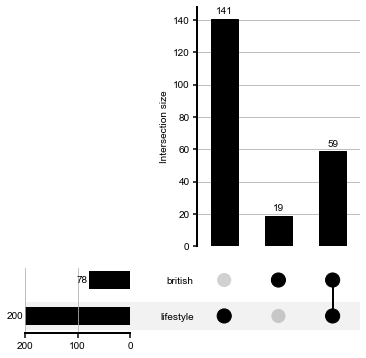

In [15]:
go_upset_df, go_unique_intersects = get_upset_df(group_gos, groups)
parsed_go_upset_df = go_upset_df.loc[go_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(6, 6))
upsetplot.plot(parsed_go_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

In [16]:
go_unique_intersects.keys()

dict_keys([(('british',), ('lifestyle',)), (('lifestyle',), ('british',)), (('british', 'lifestyle'), ())])

In [17]:
go_unique_intersects[(('british', 'lifestyle'), ())]

{'Actin Filament Organization (GO:0007015)',
 'Actin Filament-Based Transport (GO:0099515)',
 'Actin-Myosin Filament Sliding (GO:0033275)',
 'Actomyosin Structure Organization (GO:0031032)',
 'Branching Morphogenesis Of An Epithelial Tube (GO:0048754)',
 'Calcium Ion Import Across Plasma Membrane (GO:0098703)',
 'Calcium Ion Transmembrane Import Into Cytosol (GO:0097553)',
 'Calcium Ion Transmembrane Transport (GO:0070588)',
 'Calcium Ion Transport (GO:0006816)',
 'Cardiac Conduction (GO:0061337)',
 'Cardiac Muscle Contraction (GO:0060048)',
 'Chloride Transport (GO:0006821)',
 'Collagen Fibril Organization (GO:0030199)',
 'Epithelial Cell Differentiation (GO:0030855)',
 'Epithelium Development (GO:0060429)',
 'External Encapsulating Structure Organization (GO:0045229)',
 'Extracellular Matrix Organization (GO:0030198)',
 'Extracellular Structure Organization (GO:0043062)',
 'Glucan Catabolic Process (GO:0009251)',
 'Glutamate Receptor Signaling Pathway (GO:0007215)',
 'Heart Contracti

In [18]:
go_unique_intersects[(('lifestyle',), ('british',))]

{"3'-Phosphoadenosine 5'-Phosphosulfate Metabolic Process (GO:0050427)",
 'ATP Metabolic Process (GO:0046034)',
 'AV Node Cell Action Potential (GO:0086016)',
 'Action Potential (GO:0001508)',
 'Alpha-Amino Acid Metabolic Process (GO:1901605)',
 'Amino Acid Transmembrane Transport (GO:0003333)',
 'Amino Acid Transport (GO:0006865)',
 'Ammonium Transmembrane Transport (GO:0072488)',
 'Anterograde Trans-Synaptic Signaling (GO:0098916)',
 'Aortic Valve Development (GO:0003176)',
 'Aortic Valve Morphogenesis (GO:0003180)',
 'Aspartate Family Amino Acid Metabolic Process (GO:0009066)',
 'Atrioventricular Valve Development (GO:0003171)',
 'Atrioventricular Valve Morphogenesis (GO:0003181)',
 'Bicarbonate Transport (GO:0015701)',
 'Bile Acid And Bile Salt Transport (GO:0015721)',
 'Calcium Ion Homeostasis (GO:0055074)',
 'Calcium Ion Import (GO:0070509)',
 'Carbohydrate Catabolic Process (GO:0016052)',
 'Carbohydrate Phosphorylation (GO:0046835)',
 'Cardiac Muscle Cell Action Potential (GO:00

# KEGG terms

In [19]:
group_keggs = list(map(read_enrich_files, kegg_enrich_files))

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


(0.0, 1.0, 0.0, 1.0)

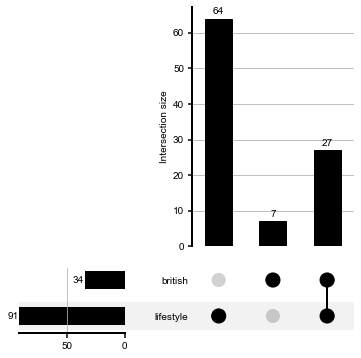

In [20]:
kegg_upset_df, kegg_unique_intersects = get_upset_df(group_keggs, groups)
parsed_kegg_upset_df = kegg_upset_df.loc[kegg_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(6, 6))
upsetplot.plot(parsed_kegg_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

In [21]:
kegg_unique_intersects[(('british', 'lifestyle'), ())]

{'ABC transporters',
 'Arrhythmogenic right ventricular cardiomyopathy',
 'Ascorbate and aldarate metabolism',
 'Bile secretion',
 'Breast cancer',
 'Carbohydrate digestion and absorption',
 'Chemical carcinogenesis',
 'Cholinergic synapse',
 'Dilated cardiomyopathy',
 'Drug metabolism',
 'ECM-receptor interaction',
 'Focal adhesion',
 'Fructose and mannose metabolism',
 'Galactose metabolism',
 'Glycine serine and threonine metabolism',
 'Human papillomavirus infection',
 'Hypertrophic cardiomyopathy',
 'Mineral absorption',
 'PI3K-Akt signaling pathway',
 'Pathways of neurodegeneration',
 'Pentose and glucuronate interconversions',
 'Porphyrin and chlorophyll metabolism',
 'Protein digestion and absorption',
 'Retinol metabolism',
 'Starch and sucrose metabolism',
 'Steroid hormone biosynthesis',
 'Vitamin digestion and absorption'}

In [22]:
kegg_unique_intersects[(('lifestyle',), ('british',))]

{'Adrenergic signaling in cardiomyocytes',
 'Aldosterone synthesis and secretion',
 'Amino sugar and nucleotide sugar metabolism',
 'Amoebiasis',
 'Apelin signaling pathway',
 'Calcium signaling pathway',
 'Cardiac muscle contraction',
 'Cholesterol metabolism',
 'Circadian entrainment',
 'Collecting duct acid secretion',
 'Complement and coagulation cascades',
 'Cortisol synthesis and secretion',
 'Cushing syndrome',
 'Estrogen signaling pathway',
 'Fat digestion and absorption',
 'Fatty acid degradation',
 'Folate biosynthesis',
 'Gastric acid secretion',
 'Glucagon signaling pathway',
 'Glutamatergic synapse',
 'Glycerolipid metabolism',
 'Glycolysis / Gluconeogenesis',
 'Glycosaminoglycan degradation',
 'Glyoxylate and dicarboxylate metabolism',
 'GnRH secretion',
 'Growth hormone synthesis secretion and action',
 'Histidine metabolism',
 'Inositol phosphate metabolism',
 'Insulin signaling pathway',
 'Lysine degradation',
 'Lysosome',
 'Mismatch repair',
 'Neomycin kanamycin and g

In [16]:
kegg_unique_intersects.keys()

dict_keys([(('british',), ('lifestyle',)), (('lifestyle',), ('british',)), (('british', 'lifestyle'), ())])

# KEGG unique intersect genes

## Lifestyle

In [23]:
def get_unique_genes_from_terms(enrich_df, term_unique_intersects, gene_unique_intersects, ut_key):
    unique_terms = term_unique_intersects[ut_key]
    enrich_df = enrich_df.loc[enrich_df.Term.isin(unique_terms)]
    unique_genes = gene_unique_intersects[ut_key]
    enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))
    return enrich_df
    

In [24]:
kegg_lifetyle_df = pd.read_csv(kegg_enrich_files[1])
kegg_lifetyle_df = get_unique_genes_from_terms(kegg_lifetyle_df, kegg_unique_intersects, gene_unique_intersects,(('lifestyle',), ('british',)))

/tmp/ipykernel_83095/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


In [37]:
kegg_lifetyle_df.sort_values("adj_pval").tail(50)

,Term,p_val,adj_pval,odds_ratio,combined_score,genes
32,Folate biosynthesis,0.000191,0.001782,5.705621,48.860966,FPGS|AKR1B10|ALPP|ALPG|TH
33,Cholesterol metabolism,0.000212,0.001863,3.791778,32.070020,APOB|ABCB11|ABCG8|ABCG5|LIPC|LCAT|NPC2
34,Estrogen signaling pathway,0.000218,0.001863,2.416724,20.377527,GNAI3|KRT9|ITPR2|KRT20|ADCY6|OPRM1|KRT32|KRT40...
35,Insulin signaling pathway,0.000218,0.001863,2.416724,20.377527,HKDC1|PHKA2|TSC1|TRIP10|INPPL1|HK3|HK2|PRKAR1B...
36,Calcium signaling pathway,0.000238,0.001982,2.007991,16.752467,EGF|CACNA1G|PHKA2|ITPR2|PHKA1|PHKB|CACNA1E|PDE...
37,Synaptic vesicle cycle,0.000254,0.002055,3.011009,24.930838,SLC18A1|ATP6V0A2|TCIRG1|SLC17A8|DNM2|UNC13C|DN...
42,Valine leucine and isoleucine degradation,0.000544,0.003838,3.595253,27.022019,AOX1|ALDH7A1|ACADM|MCCC1|HMGCLL1|ACAA2|ACADSB|...
43,Cardiac muscle contraction,0.000548,0.003838,2.782081,20.890024,ATP2A1|TNNT2|CACNB1|CACNB2|CACNB4
45,Glyoxylate and dicarboxylate metabolism,0.000640,0.004203,4.617748,33.960997,ACO2|CAT|AGXT|AMT|HAO1
46,Cushing syndrome,0.000641,0.004203,2.181372,16.037159,CACNA1G|GNAI3|APC|WDR5B|ITPR2|ADCY6|CYP21A2|AP...


In [33]:
kegg_lifetyle_df.loc[kegg_lifetyle_df.Term.str.contains("cAMP signaling pathway"), "genes"].values[0]

'EP300|RAPGEF4|CREBBP|ARAP3|ATP2A1|CNGA2|ADCY7|PLD1|NFKBIA|GLI3|GNAI3|CNGA4|TSHR|NFATC1|ADCY6|PDE3B|GLI1|CALML4|PPARA'

In [35]:
kegg_lifetyle_df.loc[kegg_lifetyle_df.Term.str.contains("Cholesterol metabolism"), "genes"].values[0]

'APOB|ABCB11|ABCG8|ABCG5|LIPC|LCAT|NPC2'

In [38]:

kegg_lifetyle_df.loc[kegg_lifetyle_df.Term.str.contains("Insulin signaling pathway"), "genes"].values[0]


'HKDC1|PHKA2|TSC1|TRIP10|INPPL1|HK3|HK2|PRKAR1B|PYGL|PRKCZ|PDE3B|PCK2|PHKB|PHKA1|MTOR|CALML4'

In [39]:
go_lifetyle_df = pd.read_csv(go_enrich_files[1])
go_lifetyle_df = get_unique_genes_from_terms(go_lifetyle_df, go_unique_intersects, gene_unique_intersects,(('lifestyle',), ('british',)))

/tmp/ipykernel_83095/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


In [40]:
go_lifetyle_df.head(50)

,Term,p_val,adj_pval,odds_ratio,combined_score,genes
21,Carbohydrate Catabolic Process (GO:0016052),8.125207e-09,0.000001,8.003632,149.094024,PGAM1|GPI|LDHA|HKDC1|HK3|HK2|PKM|PFKFB2|PFKL|A...
25,Monoatomic Cation Transport (GO:0006812),1.976839e-08,0.000003,7.362474,130.604272,ATP10D|CNGA4|ANO6|PIEZO1|ANO1|ANO10|PIEZO2|MCO...
26,Chloride Ion Homeostasis (GO:0055064),2.288961e-08,0.000003,86.244769,1517.268223,SLC12A2|SLC12A7|SLC12A8|SLC12A9
27,Monoatomic Anion Homeostasis (GO:0055081),2.288961e-08,0.000003,86.244769,1517.268223,SLC12A2|SLC12A7|SLC12A8|SLC12A9
29,G Protein-Coupled Glutamate Receptor Signaling...,4.048653e-08,0.000005,32.358503,550.816024,GRM7|GRM2|GRM4|HOMER1
30,Monoatomic Ion Transport (GO:0006811),4.319005e-08,0.000005,3.901915,66.167336,SLC12A2|ATP10D|CHRNA4|SLC12A7|MCOLN1|SLC34A1|S...
33,Regulation Of Extracellular Matrix Organizatio...,7.876160e-08,0.000009,11.783621,192.742812,LAMA1|LAMA2|NID1|CEL|LAMB2|RUNX1|FGFR4
38,Lipid Translocation (GO:0034204),1.452764e-07,0.000015,10.801017,170.057993,ATP10D|ATP9B|ATP8A1|ATP8B4|ATP8B3|ATP10B|SLC66A2
39,Chloride Transmembrane Transport (GO:1902476),2.008363e-07,0.000020,5.935381,91.528178,SLC12A2|ANO7|GABRG1|SLC12A7|SLC12A8|ANO6|ANO5|...
40,Glycolytic Process (GO:0006096),2.216726e-07,0.000021,8.779342,134.517635,PGAM1|GPI|LDHA|HKDC1|HK3|HK2|PKM|PFKFB2|PFKL|A...


In [41]:
go_lifetyle_df.loc[go_lifetyle_df.Term.str.contains("Cholesterol Transport")].genes.values[0]

'APOB|CEL|ABCA8|CAV1|ABCG8|ABCG5|LCAT|LIPC|NPC2'

In [42]:
go_lifetyle_df.loc[go_lifetyle_df.Term.str.contains("Central Nervous System Development"), "genes"].values[0]

'AGTR2|ZFHX3|PRKN|ZFHX2|GRIK1|CNTN5|GSN|QARS1|VAX1|COL4A1|PKD2|SNTG2|CNTNAP2|MELTF|DNER|NIPBL|BTD|SYNJ2|CTNS|SPATA5|TPP1|PAX6|CNTN6|SETD1A|PAX8|ELP3|APEX1|CHD8|CELSR1|ADGRL2|ADGRA2|PKD1|SOX8'

In [49]:
go_lifetyle_df.loc[go_lifetyle_df.Term.str.contains("Muscle Organ Development"), "genes"].values[0]

'UTRN|LAMA2|SGCE|SGCD'

In [43]:
go_lifetyle_df.sort_values("adj_pval").head(50)

,Term,p_val,adj_pval,odds_ratio,combined_score,genes
21,Carbohydrate Catabolic Process (GO:0016052),8.125207e-09,0.000001,8.003632,149.094024,PGAM1|GPI|LDHA|HKDC1|HK3|HK2|PKM|PFKFB2|PFKL|A...
25,Monoatomic Cation Transport (GO:0006812),1.976839e-08,0.000003,7.362474,130.604272,ATP10D|CNGA4|ANO6|PIEZO1|ANO1|ANO10|PIEZO2|MCO...
26,Chloride Ion Homeostasis (GO:0055064),2.288961e-08,0.000003,86.244769,1517.268223,SLC12A2|SLC12A7|SLC12A8|SLC12A9
27,Monoatomic Anion Homeostasis (GO:0055081),2.288961e-08,0.000003,86.244769,1517.268223,SLC12A2|SLC12A7|SLC12A8|SLC12A9
29,G Protein-Coupled Glutamate Receptor Signaling...,4.048653e-08,0.000005,32.358503,550.816024,GRM7|GRM2|GRM4|HOMER1
30,Monoatomic Ion Transport (GO:0006811),4.319005e-08,0.000005,3.901915,66.167336,SLC12A2|ATP10D|CHRNA4|SLC12A7|MCOLN1|SLC34A1|S...
33,Regulation Of Extracellular Matrix Organizatio...,7.876160e-08,0.000009,11.783621,192.742812,LAMA1|LAMA2|NID1|CEL|LAMB2|RUNX1|FGFR4
38,Lipid Translocation (GO:0034204),1.452764e-07,0.000015,10.801017,170.057993,ATP10D|ATP9B|ATP8A1|ATP8B4|ATP8B3|ATP10B|SLC66A2
39,Chloride Transmembrane Transport (GO:1902476),2.008363e-07,0.000020,5.935381,91.528178,SLC12A2|ANO7|GABRG1|SLC12A7|SLC12A8|ANO6|ANO5|...
40,Glycolytic Process (GO:0006096),2.216726e-07,0.000021,8.779342,134.517635,PGAM1|GPI|LDHA|HKDC1|HK3|HK2|PKM|PFKFB2|PFKL|A...
